# SD 1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.3 MB/s eta 0:00:00

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 40, 6, 1, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (40, 6, 1, 5)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/41 [00:00<?, ?it/s]

Total execution time: 0.06s


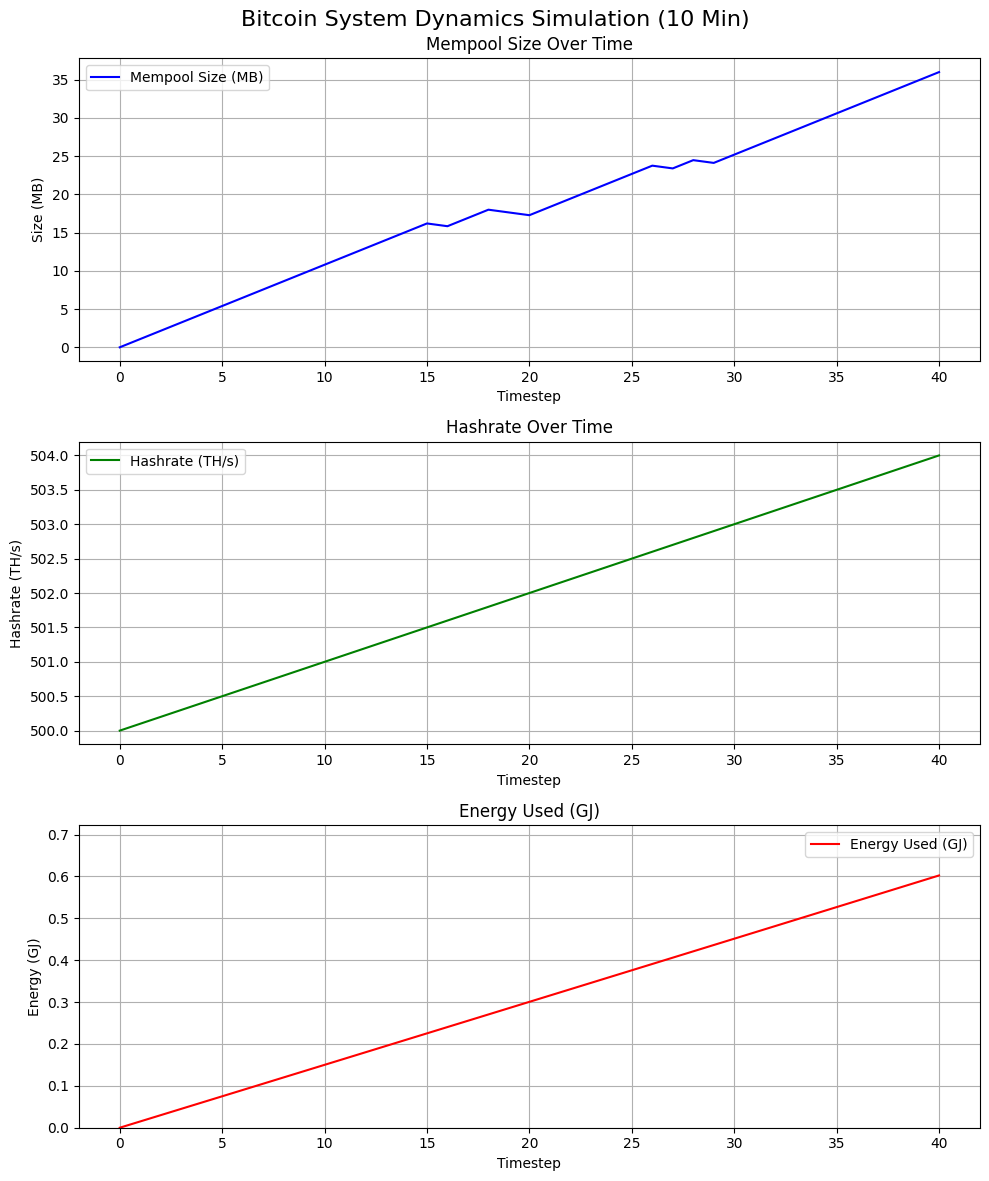

Total blocks produced: 0.33
Total transactions processed: 666.67
Transaction Throughput: 4000.00 tx/hour
Final Mempool Size: 36.00 MB
Final Hashrate: 504.00 TH/s
Energy Used: 0.60 GJ
Final Bitcoin Supply: 19750001.04 BTC


In [1]:
# Install cadCAD in Colab
!pip install cadCAD

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Initial State (Stocks) ---
initial_state = {
    'bitcoin_supply': 19750000,  # ~19.75M BTC in 2025 (post-2024 halving)
    'hashrate': 500,  # 500 TH/s (scaled for small network)
    'mempool_size': 0,  # MB of pending transactions
    'energy_used': 0,  # GJ
    'difficulty': 1.0  # Initial difficulty
}

# --- Parameters ---
params = {
    'block_reward': 3.125,  # Post-2024 halving reward
    'block_time_target': 600,  # 10 minutes in seconds
    'tx_per_block': 2000,  # Average transactions per block (from ABM)
    'avg_tx_size': 720,  # Average transaction size in bytes (Trader type from ABM)
    'energy_per_hash': 2e-6,  # Matches ~0.6 GJ over 10 min
    'tx_request_rate': 100  # 1500 tx/timestep
}

# --- State Update Functions ---
def update_bitcoin_supply(params, step, sL, s, _input):
    supply = s['bitcoin_supply']
    block_production_rate = _input.get('block_production_rate', 0)
    new_supply = supply + params['block_reward'] * block_production_rate
    return ('bitcoin_supply', new_supply)

def update_hashrate(params, step, sL, s, _input):
    hashrate = s['hashrate']
    hashrate_growth = 0.1  # Constant growth
    new_hashrate = hashrate + hashrate_growth
    return ('hashrate', max(new_hashrate, 0))

def update_mempool_size(params, step, sL, s, _input):
    mempool_size = s['mempool_size']
    tx_request_rate = _input.get('tx_request_rate', 0)
    tx_confirmation_rate = _input.get('tx_confirmation_rate', 0)
    mempool_change = (tx_request_rate - tx_confirmation_rate) * params['avg_tx_size'] / 1e6
    new_mempool_size = max(mempool_size + mempool_change, 0)
    return ('mempool_size', new_mempool_size)

def update_energy_used(params, step, sL, s, _input):
    energy = s['energy_used']
    hashrate = s['hashrate']
    energy_increment = (hashrate * 1e9) * params['energy_per_hash'] * 15 / 1e9  # GJ
    return ('energy_used', energy + energy_increment)

def update_difficulty(params, step, sL, s, _input):
    difficulty = s['difficulty']
    hashrate = s['hashrate']
    block_time = (step + 1) * 15  # Total elapsed time in seconds
    target_block_time = params['block_time_target']
    adjustment_factor = block_time / target_block_time if block_time > 0 else 1
    new_difficulty = difficulty * adjustment_factor
    return ('difficulty', max(new_difficulty, 1.0))

# --- Policy Functions ---
def network_policy(params, step, sL, s):
    hashrate = s['hashrate']
    difficulty = s['difficulty']
    # Adjust denominator to target ~1 block in 40 timesteps, add stochasticity
    block_chance = hashrate / (difficulty * 2000)  # ~0.25 chance per timestep
    block_produced = 1 if np.random.random() < block_chance else 0
    block_production_rate = block_produced / 15  # Per second (15-second timestep)

    tx_request_rate = params['tx_request_rate'] * 15
    tx_confirmation_rate = params['tx_per_block'] * block_production_rate * 15

    return {
        'block_production_rate': float(block_production_rate),
        'tx_request_rate': float(tx_request_rate),
        'tx_confirmation_rate': float(tx_confirmation_rate)
    }

# --- Partial State Update Blocks ---
partial_state_update_blocks = [
    {
        'policies': {'p1': network_policy},
        'variables': {
            'bitcoin_supply': update_bitcoin_supply,
            'hashrate': update_hashrate,
            'mempool_size': update_mempool_size,
            'energy_used': update_energy_used,
            'difficulty': update_difficulty
        }
    }
]

# --- Simulation Configuration ---
sim_config = config_sim({
    'N': 1,
    'T': range(40),  # 40 steps = 10 minutes (15 seconds/step)
    'M': params
})

# --- Experiment Setup ---
exp = Experiment()
exp.append_configs(
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=sim_config
)

# --- Execution ---
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_result, tensor_field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)

# --- Visualization ---
final_substep = result[result['substep'] == result.groupby('timestep')['substep'].transform('max')]
timesteps = final_substep['timestep']
bitcoin_supply = final_substep['bitcoin_supply']
hashrate = final_substep['hashrate']
mempool_size = final_substep['mempool_size']
energy_used = final_substep['energy_used']

# Create plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Bitcoin System Dynamics Simulation (10 Min)', fontsize=16)

ax1.plot(timesteps, mempool_size, 'b-', label="Mempool Size (MB)")
ax2.plot(timesteps, hashrate, 'g-', label="Hashrate (TH/s)")
ax3.plot(timesteps, energy_used, 'r-', label="Energy Used (GJ)")

ax1.set_title("Mempool Size Over Time")
ax2.set_title("Hashrate Over Time")
ax3.set_title("Energy Used (GJ)")
ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
ax3.set_xlabel("Timestep")
ax1.set_ylabel("Size (MB)")
ax2.set_ylabel("Hashrate (TH/s)")
ax3.set_ylabel("Energy (GJ)")
ax3.set_ylim(0, max(energy_used) * 1.2)
ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

plt.tight_layout()
plt.show()

# --- Metrics ---
total_blocks = (final_substep['bitcoin_supply'].iloc[-1] - final_substep['bitcoin_supply'].iloc[0]) / params['block_reward']
total_tx = total_blocks * params['tx_per_block']
simulation_time_hours = 40 * 15 / 3600
throughput = total_tx / simulation_time_hours if simulation_time_hours > 0 else 0

print(f"Total blocks produced: {total_blocks:.2f}")
print(f"Total transactions processed: {total_tx:.2f}")
print(f"Transaction Throughput: {throughput:.2f} tx/hour")
print(f"Final Mempool Size: {mempool_size.iloc[-1]:.2f} MB")
print(f"Final Hashrate: {hashrate.iloc[-1]:.2f} TH/s")
print(f"Energy Used: {energy_used.iloc[-1]:.2f} GJ")
print(f"Final Bitcoin Supply: {bitcoin_supply.iloc[-1]:.2f} BTC")